# The Aiyagari Model

```{include} _admonition/gpu.md
```

## Overview

In this lecture, we describe the structure of a class of models that build on work by Truman Bewley [[Bew77](https://python.quantecon.org/zreferences.html#id173)].

We begin by discussing an example of a Bewley model due to Rao Aiyagari [[Aiy94](https://python.quantecon.org/zreferences.html#id137)].

The model features

- Heterogeneous agents
- A single exogenous vehicle for borrowing and lending
- Limits on amounts individual agents may borrow


The Aiyagari model has been used to investigate many topics, including

- precautionary savings and the effect of liquidity constraints [[Aiy94](https://python.quantecon.org/zreferences.html#id138)]
- risk sharing and asset pricing [[HL96](https://python.quantecon.org/zreferences.html#id130)]
- the shape of the wealth distribution [[BBZ15](https://python.quantecon.org/zreferences.html#id131)]


### References

The primary reference for this lecture is [[Aiy94](https://python.quantecon.org/zreferences.html#id138)].

A textbook treatment is available in chapter 18 of [[LS18](https://python.quantecon.org/zreferences.html#id183)].

A less sophisticated version of this lecture (without JAX) can be found
[here](https://python.quantecon.org/aiyagari.html).


### Preliminaries

We use the following imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

Let's check the GPU we are running

In [2]:
!nvidia-smi

Tue May 16 11:05:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   29C    P0    38W / 300W |      0MiB / 16160MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


We will use 64 bit floats with JAX in order to increase the precision.

In [3]:
jax.config.update("jax_enable_x64", True)

We will use the following function to compute stationary distributions of stochastic matrices.  (For a reference to the algorithm, see p. 88 of [Economic Dynamics](https://johnstachurski.net/edtc).)

In [4]:
# Compute the stationary distribution of P by matrix inversion.

@jax.jit
def compute_stationary(P):
    n = P.shape[0]
    I = jnp.identity(n)
    O = jnp.ones((n, n))
    A = I - jnp.transpose(P) + O
    return jnp.linalg.solve(A, jnp.ones(n))

## Firms

Firms produce output by hiring capital and labor.

Firms act competitively and face constant returns to scale.

Since returns to scale are constant the number of firms does not matter.

Hence we can consider a single (but nonetheless competitive) representative firm.

The firm’s output is

$$
Y_t = A K_t^{\alpha} N^{1 - \alpha}
$$

where

- $ A $ and $ \alpha $ are parameters with $ A > 0 $ and $ \alpha \in (0, 1) $
- $ K_t $ is aggregate capital
- $ N $ is total labor supply (which is constant in this simple version of the model)


The firm’s problem is

$$
\max_{K, N} \left\{ A K_t^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\}
$$

The parameter $ \delta $ is the depreciation rate.

From the first-order condition with respect to capital, the firm’s inverse demand for capital is


```{math}
:label: equation-aiy-rgk
r = A \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta
```

Using this expression and the firm’s first-order condition for labor, we can pin down
the equilibrium wage rate as a function of $ r $ as


```{math}
:label: equation-aiy-wgr
w(r) = A  (1 - \alpha)  (A \alpha / (r + \delta))^{\alpha / (1 - \alpha)}
```

These parameters and equations are stored in the following class.

In [5]:
class Firm:

    def __init__(self,
                 A=1.0,
                 N=1.0,
                 α=0.33,
                 β=0.96,
                 δ=0.05):

        self.A, self.N, self.α, self.β, self.δ = A, N, α, β, δ

    def rd(self, K):
        """
        Inverse demand curve for capital.  The interest rate associated with a
        given demand for capital K.
        """
        A, N, α, β, δ = self.A, self.N, self.α, self.β, self.δ
        return A * α * (N / K)**(1 - α) - δ


    def r_to_w(self, r):
        """
        Equilibrium wages associated with a given interest rate r.
        """
        A, N, α, β, δ = self.A, self.N, self.α, self.β, self.δ
        return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

## Households

Infinitely lived households / consumers face idiosyncratic income shocks.

A unit interval of  *ex-ante* identical households face a common borrowing constraint.

The savings problem faced by a typical  household is

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
a_{t+1} + c_t \leq w z_t + (1 + r) a_t
\quad
c_t \geq 0,
\quad \text{and} \quad
a_t \geq -B
$$

where

- $ c_t $ is current consumption
- $ a_t $ is assets
- $ z_t $ is an exogenous component of labor income capturing stochastic unemployment risk, etc.
- $ w $ is a wage rate
- $ r $ is a net interest rate
- $ B $ is the maximum amount that the agent is allowed to borrow


The exogenous process $ \{z_t\} $ follows a finite state Markov chain with given stochastic matrix $ P $.


In this simple version of the model, households supply labor  inelastically because they do not value leisure.

Below we provide code to solve the household problem, taking $r$ and $w$ as fixed.

For now we assume that $u(c) = \log(c)$.

(CRRA utility is treated in the exercises.)



### Primitives and Operators

This class stores the parameters that define a household asset
accumulation problem and the grids used to solve it.

In [6]:
class Household:

    def __init__(self,
                r=0.01,                      # Interest rate
                w=1.0,                       # Wages
                β=0.96,                      # Discount factor
                Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                z_grid=[0.1, 1.0],           # Exogenous states
                a_min=1e-10, a_max=20,       # Asset grid
                a_size=200):

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_size = a_size
        self.a_grid = jnp.linspace(a_min, a_max, a_size)
        z_grid, Π = map(jnp.array, (z_grid, Π))
        self.Π = jax.device_put(Π)
        self.z_grid = jax.device_put(z_grid)
        self.z_size = len(z_grid)

    def constants(self):
        return self.r, self.w, self.β

    def sizes(self):
        return self.a_size, self.z_size

    def arrays(self):
        return self.a_grid, self.z_grid, self.Π

In [7]:
@jax.jit
def u(c):
    return jnp.log(c)

This is the vectorized version of the right-hand side of the Bellman equation
(before maximization), which is a 3D array representing

$$
        B(a, z, a') = u(wz + (1+r)a - a') + \beta \sum_{z'} v(a', z') Π(z, z')
$$
for all $(a, z, a')$.

In [8]:
def B(v, constants, sizes, arrays):
    # Unpack
    r, w, β = constants
    a_size, z_size = sizes
    a_grid, z_grid, Π = arrays

    # Compute current consumption as array c[i, j, ip]
    a  = jnp.reshape(a_grid, (a_size, 1, 1))    # a[i]   ->  a[i, j, ip]
    z  = jnp.reshape(z_grid, (1, z_size, 1))    # z[j]   ->  z[i, j, ip]
    ap = jnp.reshape(a_grid, (1, 1, a_size))    # ap[ip] -> ap[i, j, ip]
    c = w*z + (1 + r)*a - ap

    # Calculate continuation rewards at all combinations of (a, z, ap)
    v = jnp.reshape(v, (1, 1, a_size, z_size))  # v[ip, jp] -> v[i, j, ip, jp]
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))  # Π[j, jp]  -> Π[i, j, ip, jp]
    EV = jnp.sum(v * Π, axis=3)                 # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, u(c) + β * EV, -jnp.inf)

B = jax.jit(B, static_argnums=(2,))

The next function computes greedy policies.

In [9]:
# Computes a v-greedy policy, returned as a set of indices
def get_greedy(v, constants, sizes, arrays):
    return jnp.argmax(B(v, constants, sizes, arrays), axis=2)

get_greedy = jax.jit(get_greedy, static_argnums=(2,))

We need to know rewards at a given policy for policy iteration.

The following functions computes the array $r_{\sigma}$ which gives current
rewards given policy $\sigma$.

That is,

$$
    r_{\sigma}[i, j] = r[i, j, \sigma[i, j]]
$$

In [10]:
def compute_r_σ(σ, constants, sizes, arrays):
    # Unpack
    r, w, β = constants
    a_size, z_size = sizes
    a_grid, z_grid, Π = arrays

    # Compute r_σ[i, j]
    a = jnp.reshape(a_grid, (a_size, 1))
    z = jnp.reshape(z_grid, (1, z_size))
    ap = a_grid[σ]
    c = (1 + r)*a + w*z - ap
    r_σ = u(c)

    return r_σ

compute_r_σ = jax.jit(compute_r_σ, static_argnums=(2,))

The value $v_{\sigma}$ of a policy $\sigma$ is defined as

$$
    v_{\sigma} = (I - \beta P_{\sigma})^{-1} r_{\sigma}
$$

Here we set up the linear map $v \rightarrow R_{\sigma} v$, where $R_{\sigma} := I - \beta P_{\sigma}$.

In the consumption problem, this map can be expressed as

$$
    (R_{\sigma} v)(a, z) = v(a, z) - \beta \sum_{z'} v(\sigma(a, z), z') Π(z, z')
$$

Defining the map as above works in a more intuitive multi-index setting
(e.g. working with $v[i, j]$ rather than flattening $v$ to a one-dimensional
array) and avoids instantiating the large matrix $P_{\sigma}$.

The following linear operator is also needed for policy iteration.

In [11]:
def R_σ(v, σ, constants, sizes, arrays):
    # Unpack
    r, w, β = constants
    a_size, z_size = sizes
    a_grid, z_grid, Π = arrays

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(z_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, z_size))
    σ = jnp.reshape(σ, (a_size, z_size, 1))
    V = v[σ, zp_idx]

    # Expand Π[j, jp] to Π[i, j, jp]
    Π = jnp.reshape(Π, (1, z_size, z_size))

    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Π[j, jp]
    return v - β * jnp.sum(V * Π, axis=2)

R_σ = jax.jit(R_σ, static_argnums=(3,))

The next function computes the lifetime value of a given policy.

In [12]:
# Get the value v_σ of policy σ by inverting the linear map R_σ

def get_value(σ, constants, sizes, arrays):

    r_σ = compute_r_σ(σ, constants, sizes, arrays)
    # Reduce R_σ to a function in v
    partial_R_σ = lambda v: R_σ(v, σ, constants, sizes, arrays)
    # Compute inverse v_σ = (I - β P_σ)^{-1} r_σ
    return jax.scipy.sparse.linalg.bicgstab(partial_R_σ, r_σ)[0]

get_value = jax.jit(get_value, static_argnums=(2,))

The following function is used for optimistic policy iteration.

In [13]:
def T_σ(v, σ, constants, sizes, arrays):
    "The σ-policy operator."

    # Unpack model
    γ, w, β = constants
    a_size, z_size = sizes
    a_grid, z_grid, Π = arrays

    r_σ = compute_r_σ(σ, constants, sizes, arrays)

    # Compute the array v[σ[i, j], jp]
    zp_idx = jnp.arange(z_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, z_size))
    σ = jnp.reshape(σ, (a_size, z_size, 1))
    V = v[σ, zp_idx]

    # Convert Q[j, jp] to Q[i, j, jp]
    Π = jnp.reshape(Π, (1, z_size, z_size))

    # Calculate the expected sum Σ_jp v[σ[i, j], jp] * Q[i, j, jp]
    Ev = jnp.sum(V * Π, axis=2)

    return r_σ + β * jnp.sum(V * Π, axis=2)

T_σ = jax.jit(T_σ, static_argnums=(3,))

## Solvers

We will solve the household problem using Howard policy iteration.

In [14]:
def policy_iteration(household, verbose=True):
    """Howard policy iteration routine."""
    constants = household.constants()
    sizes = household.sizes()
    arrays = household.arrays()

    vz = jnp.zeros(sizes)
    σ = jnp.zeros(sizes, dtype=int)
    i, error = 0, 1.0
    while error > 0:
        v_σ = get_value(σ, constants, sizes, arrays)
        σ_new = get_greedy(v_σ, constants, sizes, arrays)
        error = jnp.max(jnp.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        if verbose:
            print(f"Concluded loop {i} with error {error}.")
    return σ

We can also solve the problem using optimistic policy iteration.

In [15]:
def optimistic_policy_iteration(household, tol=1e-5, m=10):
    constants = household.constants()
    sizes = household.sizes()
    arrays = household.arrays()

    v = jnp.zeros(sizes)
    error = tol + 1
    while error > tol:
        last_v = v
        σ = get_greedy(v, constants, sizes, arrays)
        for _ in range(m):
            v = T_σ(v, σ, constants, sizes, arrays)
        error = jnp.max(jnp.abs(v - last_v))
    return get_greedy(v, constants, sizes, arrays)

As a first example of what we can do, let’s compute and plot an optimal accumulation policy at fixed prices.

In [16]:
# Example prices
r = 0.03
w = 0.956

# Create an instance of Housbehold
household = Household(r=r, w=w)

In [17]:
%%time

σ_star_hpi = policy_iteration(household)

Concluded loop 1 with error 101.
Concluded loop 2 with error 76.
Concluded loop 3 with error 36.
Concluded loop 4 with error 17.
Concluded loop 5 with error 12.
Concluded loop 6 with error 6.
Concluded loop 7 with error 3.
Concluded loop 8 with error 2.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.
Concluded loop 11 with error 1.
Concluded loop 12 with error 1.
Concluded loop 13 with error 1.
Concluded loop 14 with error 1.
Concluded loop 15 with error 0.
CPU times: user 1.85 s, sys: 184 ms, total: 2.03 s
Wall time: 1.59 s


In [18]:
%%time

σ_star = optimistic_policy_iteration(household)

CPU times: user 506 ms, sys: 85.6 ms, total: 591 ms
Wall time: 563 ms


The next plot shows asset accumulation policies at different values of the exogenous state.

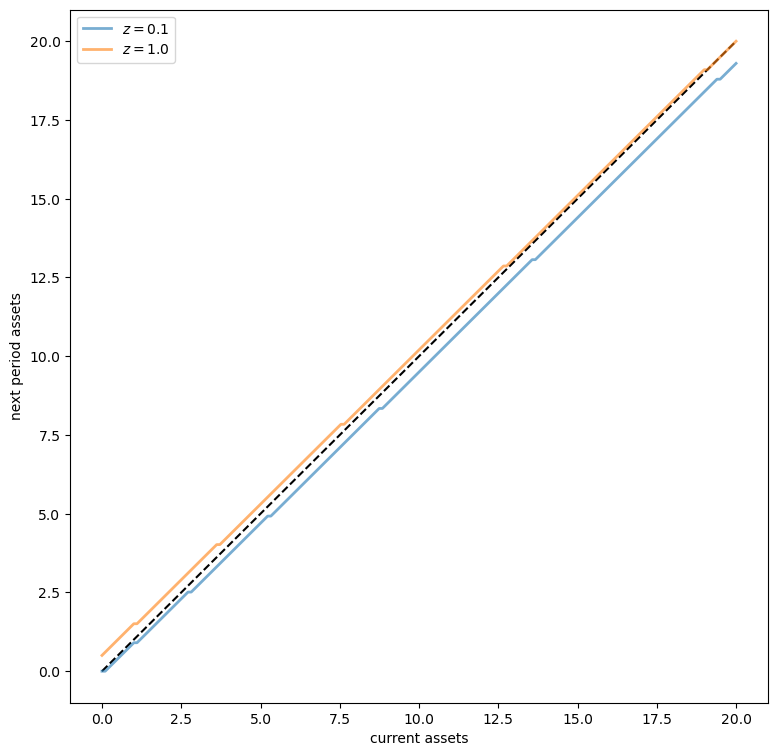

In [19]:
a_size, z_size = household.sizes()
a_grid, z_grid, Π = household.arrays()

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_grid, a_grid, 'k--')  # 45 degrees
for j in range(z_size):
    lb = f'$z = {z_grid[j]:.2}$'
    ax.plot(a_grid, a_grid[σ_star[:, j]], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')

plt.show()

### Capital Supply

To start thinking about equilibrium, we need to know how much capital households supply at a given interest rate $r$.

This quantity can be calculated by taking the stationary distribution of assets under the optimal policy and computing the mean.

The next function implements this calculation for a given policy $\sigma$.

First we compute the stationary distribution of $P_{\sigma}$, which is for the
bivariate Markov chain of the state $(a_t, z_t)$.  Then we sum out
$z_t$ to get the marginal distribution for $a_t$.

In [20]:
def compute_asset_stationary(σ, constants, sizes, arrays):

    # Unpack
    r, w, β = constants
    a_size, z_size = sizes
    a_grid, z_grid, Π = arrays

    # Construct P_σ as an array of the form P_σ[i, j, ip, jp]
    ap_idx = jnp.arange(a_size)
    ap_idx = jnp.reshape(ap_idx, (1, 1, a_size, 1))
    σ = jnp.reshape(σ, (a_size, z_size, 1, 1))
    A = jnp.where(σ == ap_idx, 1, 0)
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))
    P_σ = A * Π

    # Reshape P_σ into a matrix
    n = a_size * z_size
    P_σ = jnp.reshape(P_σ, (n, n))

    # Get stationary distribution and reshape onto [i, j] grid
    ψ = compute_stationary(P_σ)
    ψ = jnp.reshape(ψ, (a_size, z_size))

    # Sum along the rows to get the marginal distribution of assets
    ψ_a = jnp.sum(ψ, axis=1)
    return ψ_a

compute_asset_stationary = jax.jit(compute_asset_stationary,
                                   static_argnums=(2,))

Let's give this a test run.

In [21]:
constants = household.constants()
sizes = household.sizes()
arrays = household.arrays()
ψ = compute_asset_stationary(σ_star, constants, sizes, arrays)

The distribution should sum to one:

In [22]:
ψ.sum()

Array(1., dtype=float64)

Now we are ready to compute capital supply by households given wages and interest rates.

In [23]:
def capital_supply(household):
    """
    Map household decisions to the induced level of capital stock.
    """
    constants = household.constants()
    sizes = household.sizes()
    arrays = household.arrays()

    # Compute the optimal policy
    σ_star = optimistic_policy_iteration(household)
    # Compute the stationary distribution
    ψ_a = compute_asset_stationary(σ_star, constants, sizes, arrays)

    # Return K
    return float(jnp.sum(ψ_a * household.a_grid))

## Equilibrium

We construct  a *stationary rational expectations equilibrium* (SREE).

In such an equilibrium

- prices induce behavior that generates aggregate quantities consistent with the prices
- aggregate quantities and prices are constant over time


In more detail, an SREE lists a set of prices, savings and production policies such that

- households want to choose the specified savings policies taking the prices as given
- firms maximize profits taking the same prices as given
- the resulting aggregate quantities are consistent with the prices; in particular, the demand for capital equals the supply
- aggregate quantities (defined as cross-sectional averages) are constant


In practice, once parameter values are set, we can check for an SREE by the following steps

1. pick a proposed quantity $ K $ for aggregate capital
2. determine corresponding prices, with interest rate $ r $ determined by {eq}`equation-aiy-rgk` and a wage rate $ w(r) $ as given in {eq}`equation-aiy-wgr`.
3. determine the common optimal savings policy of the households given these prices
4. compute aggregate capital as the mean of steady state capital given this savings policy


If this final quantity agrees with $ K $ then we have a SREE.  Otherwise we adjust $K$.

These steps describe a fixed point problem which we solve below.

### Visual inspection

Let’s inspect visually as a first pass.

The following code draws aggregate supply and demand curves for capital.

The intersection gives equilibrium interest rates and capital.

In [24]:
# Create default instances
household = Household()
firm = Firm()

# Create a grid of r values at which to compute demand and supply of capital
num_points = 50
r_vals = np.linspace(0.005, 0.04, num_points)

In [25]:
%%time

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    household.r = r
    household.w = firm.r_to_w(r)
    k_vals[i] = capital_supply(household)

CPU times: user 12.1 s, sys: 3.49 s, total: 15.6 s
Wall time: 5.23 s


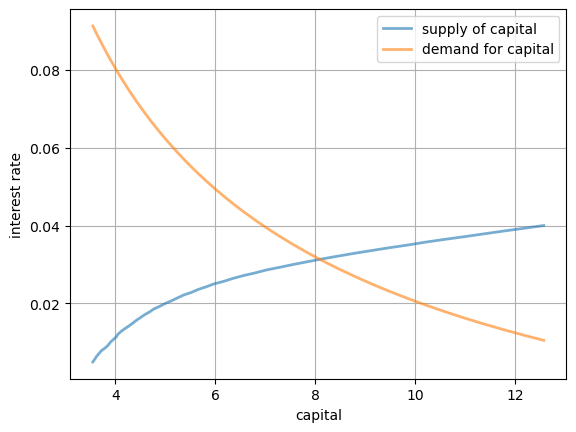

In [26]:
# Plot against demand for capital by firms

fig, ax = plt.subplots()
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, firm.rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')

plt.show()

Here's a plot of the excess demand function.

The equilibrium is the zero (root) of this function.

In [27]:
def excess_demand(K, firm, household):
    r = firm.rd(K)
    w = firm.r_to_w(r)
    household.r, household.w = r, w
    return K - capital_supply(household)

In [28]:
%%time

num_points = 50
k_vals = np.linspace(4, 12, num_points)
out = [excess_demand(k, firm, household) for k in k_vals]

CPU times: user 11.6 s, sys: 4.19 s, total: 15.8 s
Wall time: 4.9 s


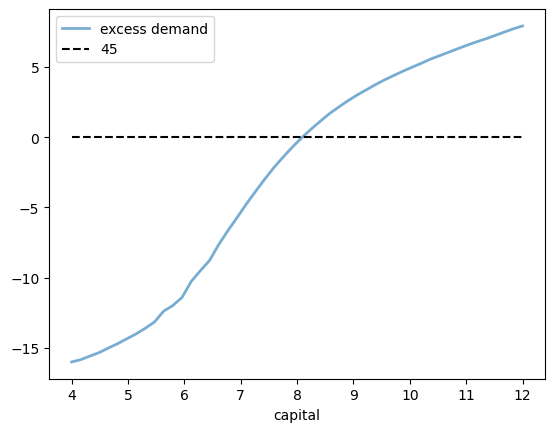

In [29]:
fig, ax = plt.subplots()
ax.plot(k_vals, out, lw=2, alpha=0.6, label='excess demand')
ax.plot(k_vals, np.zeros_like(k_vals), 'k--', label="45")
ax.set_xlabel('capital')
ax.legend()
plt.show()

### Computing the equilibrium

Now let's compute the equilibrium

To do so, we use the bisection method, which is implemented
in the next function.

In [30]:
def bisect(f, a, b, *args, tol=10e-2):
    """
    Implements the bisection root finding algorithm, assuming that f is a
    real-valued function on [a, b] satisfying f(a) < 0 < f(b).
    """
    lower, upper = a, b
    count = 0
    while upper - lower > tol and count < 10000:
        middle = 0.5 * (upper + lower)
        if f(middle, *args) > 0:   # root is between lower and middle
            lower, upper = lower, middle
        else:                      # root is between middle and upper
            lower, upper = middle, upper
        count += 1
    if count == 10000:
        print("Root might not be accurate")
    return 0.5 * (upper + lower)

Now we call the bisection function on excess demand.

In [31]:
def compute_equilibrium(household, firm):
    solution = bisect(excess_demand, 6.0, 10.0, firm, household)
    return solution

In [32]:
%%time

household = Household()
firm = Firm()
compute_equilibrium(household, firm)

CPU times: user 1.42 s, sys: 449 ms, total: 1.86 s
Wall time: 567 ms


8.09375

Notice how quickly we can compute the equilibrium capital stock using a simple
method such as bisection.


## Exercises


```{exercise-start}
:label: aygr_ex1
```
Using the default household and firm model, produce a graph
showing the behaviour of equilibrium capital stock with the increase in $\beta$.

```{exercise-end}
```

```{solution-start} aygr_ex1
:class: dropdown
```

In [33]:
β_vals = np.linspace(0.9, 0.99, 40)
eq_vals = np.empty_like(β_vals)

for i, β in enumerate(β_vals):
    household = Household(β=β)
    firm = Firm(β=β)
    eq_vals[i] = compute_equilibrium(household, firm)

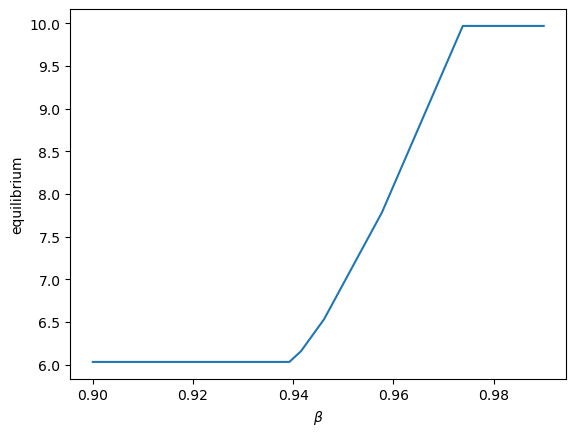

In [34]:
fig, ax = plt.subplots()
ax.plot(β_vals, eq_vals, ms=2)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('equilibrium')
plt.show()

```{solution-end}
```


```{exercise-start}
:label: aygr_ex2
```

Switch to the CRRA utility function 

$$
    u(c) =\frac{c^{1-\gamma}}{1-\gamma}
$$

and re-do the plot of demand for capital by firms against the
supply of captial. 

Also, recompute the equilibrium.

Use the default parameters for households and firms. 

Set $\gamma=2$.

```{exercise-end}
```

```{solution-start} aygr_ex2
:class: dropdown
```

Let's define the utility function

In [35]:
@jax.jit
def u(c, γ=2):
    return c**(1 - γ) / (1 - γ)

We need to re-compile all the jitted functions in order notice the change
in the utility function.

In [36]:
B = jax.jit(B, static_argnums=(2,))
get_greedy = jax.jit(get_greedy, static_argnums=(2,))
compute_r_σ = jax.jit(compute_r_σ, static_argnums=(2,))
R_σ = jax.jit(R_σ, static_argnums=(3,))
get_value = jax.jit(get_value, static_argnums=(2,))
T_σ = jax.jit(T_σ, static_argnums=(3,))
compute_asset_stationary = jax.jit(compute_asset_stationary,
                                   static_argnums=(2,))

Now, let's plot the the demand for capital by firms

In [37]:
# Create default instances
household = Household()
firm = Firm()

# Create a grid of r values at which to compute demand and supply of capital
num_points = 50
r_vals = np.linspace(0.005, 0.04, num_points)


# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    household.r = r
    household.w = firm.r_to_w(r)
    k_vals[i] = capital_supply(household)

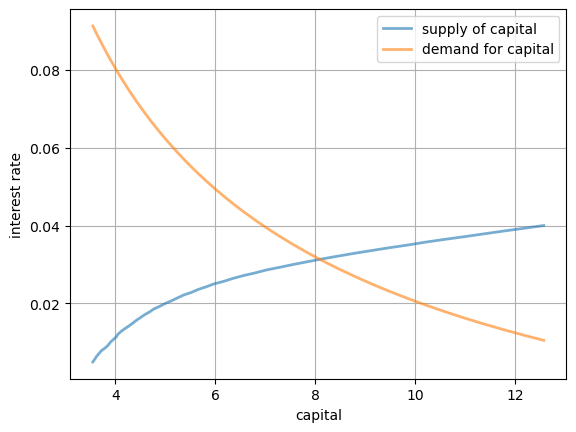

In [38]:
# Plot against demand for capital by firms

fig, ax = plt.subplots()
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, firm.rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend()

plt.show()

Compute the equilibrium

In [39]:
%%time

household = Household()
firm = Firm()
compute_equilibrium(household, firm)

CPU times: user 2 s, sys: 369 ms, total: 2.37 s
Wall time: 977 ms


8.09375

```{solution-end}
```